In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
from tqdm import tqdm
import time
from collections.abc import Iterable
import matplotlib.pyplot as plt

#### ticker/base info download

In [104]:
nasdaq_url = "ftp://ftp.nasdaqtrader.com/SymbolDirectory/nasdaqlisted.txt"
nyse_url = "ftp://ftp.nasdaqtrader.com/SymbolDirectory/otherlisted.txt"

nasdaq_data = pd.read_csv(nasdaq_url, sep='|')
nyse_data = pd.read_csv(nyse_url, sep='|')
nasdaq_data = nasdaq_data.iloc[:-1]
nyse_data = nyse_data.iloc[:-1]

nyse_data = nyse_data[(nyse_data['NASDAQ Symbol'] == nyse_data['ACT Symbol'])
                      & (nyse_data['Test Issue'] == 'N')
                      & (nyse_data['Exchange'].isin(['N', 'P']))]
nasdaq_data = nasdaq_data[nasdaq_data['Test Issue'] == 'N']

nyse_data.rename(columns={'ACT Symbol':'Symbol'}, inplace=True)
tickers = pd.concat([nyse_data[['Symbol']]
                         , nasdaq_data[['Symbol']]], axis=0)
tickers.dropna(inplace=True)
tickers = tickers[tickers['Symbol'].apply(lambda x: x.isalnum())]
tickers.reset_index(drop=True, inplace=True)

In [133]:
def get_important_info(symbol):
  infodict = yf.Ticker(symbol).info
  if len(infodict.keys()) == 1:
    print(f'no data for [{symbol}]')
    return 0
  l = []
  for k in infodict.keys():
    if type(infodict[k]) == list: l.append(k)
  for k in l: del infodict[k]
  return infodict

In [140]:
info_df = []
for sy in tqdm(list(tickers['Symbol'])):
  if (x := get_important_info(sy)): info_df.append(x)
  time.sleep(0.2)

100%|██████████| 9472/9472 [1:11:30<00:00,  2.21it/s]


In [142]:
i = pd.DataFrame(info_df)
i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9472 entries, 0 to 9471
Columns: 146 entries, address1 to pegRatio
dtypes: float64(106), int64(2), object(38)
memory usage: 10.6+ MB


In [147]:
# info_df = pd.DataFrame(info_df)
info_df.to_csv("info_df.csv", index=False, sep='\t')

#### daychart download

In [2]:
info_df = pd.read_csv('info_df.csv', sep='\t')

C:\Users\naniri\AppData\Local\Temp\ipykernel_39588\1183031005.py:1: DtypeWarning: Columns (144) have mixed types. Specify dtype option on import or set low_memory=False.
  info_df = pd.read_csv('info_df.csv', sep='\t')


In [4]:
tickers = info_df['symbol'].tolist()

In [62]:
bi = 0; dl = []
while len(tickers) > bi*100:
    data = yf.download(tickers[bi*100:bi*100+100], period="max", interval="1d")
    
    i = 0; cols = ['Adj Close', 'Close', 'Open', 'High', 'Low', 'Volume']
    dr = []
    for ch, t in data.columns:
        if ch != 'Adj Close': break
        if np.isnan(data.iat[-1, i]): 
            dr.append(t)
        i += 1

    for t in dr:
        data.drop(columns=[(c, t) for c in cols], inplace=True)
    
    dl.append(data)
    
    time.sleep(30)
    bi += 1

[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************] 

In [65]:
df = pd.concat(dl, axis=1)

In [69]:
df_mod = df.iloc[:-1]

In [76]:
df_mod.to_feather('data_yf/daily.feather')

In [25]:
info_df['exchange'].value_counts()

exchange
NYQ    2444
PCX    2221
NCM    1692
NGM    1593
NMS    1518
PNK       3
ASE       1
Name: count, dtype: int64

#### base etf download

In [30]:
base_tickers = [
    # 귀금속
    "GC=F",  # 금
    "SI=F",  # 은
    "PL=F",  # 백금
    "PA=F",  # 팔라듐

    # 에너지
    "CL=F",  # 원유 (WTI)
    "BZ=F",  # 원유 (브렌트)
    "NG=F",  # 천연가스
    "RB=F",  # 가솔린
    "HO=F",  # 난방유

    # 농산물
    "ZC=F",  # 옥수수
    "ZW=F",  # 밀
    "ZS=F",  # 대두
    "ZO=F",  # 귀리
    "CT=F",  # 면화
    "SB=F",  # 설탕
    "KC=F",  # 커피
    "CC=F",  # 코코아
    "LBS=F", # 생목재

    # 축산물
    "LE=F",  # 소고기
    "GF=F",  # 비육우
    "HE=F",  # 돼지고기

    # 산업용 금속
    "HG=F",  # 구리
    "ALI=F", # 알루미늄
]

In [31]:
data = yf.download(base_tickers, interval="1h", start="2022-11-23", end="2024-11-21")

[*********************100%***********************]  23 of 23 completed


In [34]:
data.to_feather("data_yf/raw1h.feather")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


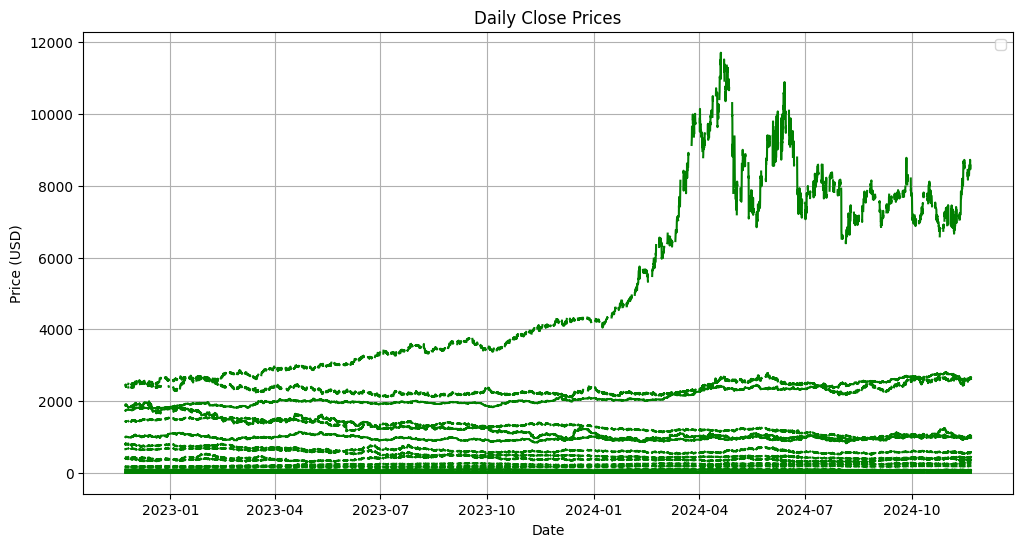

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], color='green')
plt.title("Daily Close Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()

#### read test

In [3]:
daily = pd.read_feather('data_yf/daily.feather')

In [4]:
daily

Price                       Adj Close                                        \
Ticker                              A         AA        AAA    AACT     AAM   
Date                                                                          
1962-01-02 00:00:00+00:00         NaN   1.494699        NaN     NaN     NaN   
1962-01-03 00:00:00+00:00         NaN   1.517562        NaN     NaN     NaN   
1962-01-04 00:00:00+00:00         NaN   1.517562        NaN     NaN     NaN   
1962-01-05 00:00:00+00:00         NaN   1.514704        NaN     NaN     NaN   
1962-01-08 00:00:00+00:00         NaN   1.463263        NaN     NaN     NaN   
...                               ...        ...        ...     ...     ...   
2024-11-14 00:00:00+00:00  130.220001  41.209999  25.120001  10.900  10.060   
2024-11-15 00:00:00+00:00  127.070000  44.020000  25.139999  10.880  10.050   
2024-11-18 00:00:00+00:00  126.919998  43.980000  25.094999  10.890  10.050   
2024-11-19 00:00:00+00:00  125.690002  45.599998  25.105000  10.927  10.050   
2024-11-20 00:00:00+00:00  128.570007  45.740002  25.160000  10.890  10.051   

Price                                                                          \
Ticker                           AAP    AAT         AB        ABBV       ABCB   
Date                                                                            
1962-01-02 00:00:00+00:00        NaN    NaN        NaN         NaN        NaN   
1962-01-03 00:00:00+00:00        NaN    NaN        NaN         NaN        NaN   
1962-01-04 00:00:00+00:00        NaN    NaN        NaN         NaN        NaN   
1962-01-05 00:00:00+00:00        NaN    NaN        NaN         NaN        NaN   
1962-01-08 00:00:00+00:00        NaN    NaN        NaN         NaN        NaN   
...                              ...    ...        ...         ...        ...   
2024-11-14 00:00:00+00:00  41.200001  27.24  37.029999  169.630005  69.620003   
2024-11-15 00:00:00+00:00  37.689999  27.00  36.570000  164.990005  69.629997   
2024-11-18 00:00:00+00:00  40.090000  27.07  36.639999  166.279999  68.779999   
2024-11-19 00:00:00+00:00  38.500000  27.84  36.500000  166.570007  68.709999   
2024-11-20 00:00:00+00:00  38.630001  27.67  37.169998  167.759995  68.110001   

Price                      ...   Volume                                 \
Ticker                     ...     ZOOZ         ZS      ZTEK      ZUMZ   
Date                       ...                                           
1962-01-02 00:00:00+00:00  ...      NaN        NaN       NaN       NaN   
1962-01-03 00:00:00+00:00  ...      NaN        NaN       NaN       NaN   
1962-01-04 00:00:00+00:00  ...      NaN        NaN       NaN       NaN   
1962-01-05 00:00:00+00:00  ...      NaN        NaN       NaN       NaN   
1962-01-08 00:00:00+00:00  ...      NaN        NaN       NaN       NaN   
...                        ...      ...        ...       ...       ...   
2024-11-14 00:00:00+00:00  ...  14400.0  1165200.0   26200.0  201000.0   
2024-11-15 00:00:00+00:00  ...   3700.0  1347400.0  308300.0  194600.0   
2024-11-18 00:00:00+00:00  ...   5000.0  1131300.0  258400.0  213600.0   
2024-11-19 00:00:00+00:00  ...   6700.0  1096200.0  142700.0  160000.0   
2024-11-20 00:00:00+00:00  ...  12700.0  1211700.0   38400.0  186100.0   

Price                                                                         \
Ticker                         ZURA       ZVRA       ZVSA      ZYME     ZYXI   
Date                                                                           
1962-01-02 00:00:00+00:00       NaN        NaN        NaN       NaN      NaN   
1962-01-03 00:00:00+00:00       NaN        NaN        NaN       NaN      NaN   
1962-01-04 00:00:00+00:00       NaN        NaN        NaN       NaN      NaN   
1962-01-05 00:00:00+00:00       NaN        NaN        NaN       NaN      NaN   
1962-01-08 00:00:00+00:00       NaN        NaN        NaN       NaN      NaN   
...                             ...        ...        ...       ...      ...   
2

#### Bluechip 1h

In [2]:
info_df = pd.read_csv('info_df.csv', sep='\t')

C:\Users\naniri\AppData\Local\Temp\ipykernel_15940\1183031005.py:1: DtypeWarning: Columns (144) have mixed types. Specify dtype option on import or set low_memory=False.
  info_df = pd.read_csv('info_df.csv', sep='\t')


In [ ]:
daegum = info_df['regularMarketPreviousClose'] * info_df['averageVolume10days']
daegum.sort_values(ascending=False, inplace=True)
highdaegum = info_df.loc[daegum[:1000].index, 'symbol']
targets = info_df.loc[highdaegum.index, ['symbol', 'quoteType']]

targets = targets.loc[targets['quoteType'] == 'EQUITY', 'symbol']
targets.drop(targets[targets == 'LII'].index, inplace=True)

In [32]:
targets.to_csv('data_yf/bluechip.csv')

In [15]:
bi = 0; dl = []
while len(targets) > bi*100:
    data = yf.download(targets.values.tolist()[bi*100:bi*100+100], interval="1h", start="2022-12-01", end="2024-11-25")
    
    i = 0; cols = ['Adj Close', 'Close', 'Open', 'High', 'Low', 'Volume']
    dr = []
    for ch, t in data.columns:
        if ch != 'Adj Close': break
        if np.isnan(data.iat[-1, i]): 
            dr.append(t)
        i += 1

    for t in dr:
        data.drop(columns=[(c, t) for c in cols], inplace=True)
    
    dl.append(data)
    
    time.sleep(30)
    bi += 1
    
data = pd.concat(dl, axis=1)

[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  7 of 7 completed


In [33]:
data.to_feather('data_yf/bluechip1h.feather')